In [10]:
import numpy as np
import networkx as nx
import igraph as ig
import random as random
import scipy.stats as sc
import scipy.spatial as sp
import pickle
import sys
import csv
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


## Main

In [13]:
Epinions_dir = nx.DiGraph()
a=open("soc-Epinions.txt","r") 
for i in a:  
    line=i.strip().split(' ')
    Epinions_dir.add_edge(line[0],line[1])
a.close()
G = nx.Graph(Epinions_dir)

In [18]:
cut_pcts = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.875, 0.9, 0.925, 0.95, 0.97, 0.98, 0.985, 0.99, 0.995, 0.999]

In [15]:
with open('./Epinions_clustering_result.csv', 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['G = undirected Epinions', 'H = Partially observed undirected Epinions','','','','','','','','','',''])
    writer.writerow(['Cut percent','nx.average_clustering(G)','avg_clustering(G)','avg_clustering(G,undefined=None)','iteration','Nodes','Edges','nx.average_clustering(H)','avg_clustering(H)','avg_clustering(H,undefined=None)','avg_clustering(H,observed=observed)','avg_clustering(H,observed=observed,undefined=None)'])

In [19]:
actual_nx   = 0.137756373  #nx.average_clustering(G)
actual_Zero = 0.137756373  #avg_clustering(G)
actual_None = 0.260512807  #avg_clustering(G,undefined=None)
for cut_pct in cut_pcts:
    results = []
    # run 10 times
    for iteration in range(10):
        H,observed    = make_network(G,cut_pct)
        N             = len(H.nodes()) 
        E             = len(H.edges()) 
        est_nx        = nx.average_clustering(H)
        est_Zero      = avg_clustering(H)
        est_None      = avg_clustering(H,undefined=None)
        real_est_Zero = avg_clustering(H,observed=observed)
        real_est_None = avg_clustering(H,observed=observed,undefined=None)
        result=[cut_pct,actual_nx,actual_Zero,actual_None,iteration,N,E,est_nx,est_Zero,est_None,real_est_Zero,real_est_None]
        with open('./Epinions_clustering_result.csv', 'a') as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow(result)
        results.append(result)
        print cut_pct, '  iteration:', iteration
    # average over the 10
    np_results  = np.array(results)
    averages = np.mean(np_results,axis=0).tolist()
    averages[4]='avg'
    with open('./Epinions_clustering_result.csv', 'a') as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow(averages)

0.7   iteration: 0
0.7   iteration: 1
0.7   iteration: 2
0.7   iteration: 3
0.7   iteration: 4
0.7   iteration: 5
0.7   iteration: 6
0.7   iteration: 7
0.7   iteration: 8
0.7   iteration: 9


## Functions

In [11]:
def clustering(graph, observed='all', undefined=0.0):
    results = []
    full = True if observed == 'all' else False
    if type(undefined) is int: undefined = float(undefined)
    for v in graph:
        neighbor_ids = set(graph.neighbors(v))
        intra_neighbor_ties = sum([len(set.intersection(set(graph.neighbors(neighbor)), neighbor_ids)) for neighbor in neighbor_ids])/2
        n_count = len(neighbor_ids)
        o_count = n_count if full else len(set.intersection(neighbor_ids, set(observed)))
        if not full and v in observed:
            o_triads = 0.5*o_count*(o_count-1)+(n_count-o_count)*o_count
        else:
            o_triads = 0.5*o_count*(o_count-1)
        # the canonical clustering coefficient is undefined for leaves - default is zero
        result = undefined if o_triads == 0 else float(intra_neighbor_ties)/o_triads
        results.append(result)
    return results

def avg_clustering(graph, observed='all', undefined=0.0):
    results = []
    full = True if observed == 'all' else False
    if type(undefined) is int: undefined = float(undefined)
    for v in graph:
        neighbor_ids = set(graph.neighbors(v))
        intra_neighbor_ties = sum([len(set.intersection(set(graph.neighbors(neighbor)), neighbor_ids)) for neighbor in neighbor_ids])/2
        n_count = len(neighbor_ids)
        o_count = n_count if full else len(set.intersection(neighbor_ids, set(observed)))
        if not full and v in observed:
            o_triads = 0.5*o_count*(o_count-1)+(n_count-o_count)*o_count
        else:
            o_triads = 0.5*o_count*(o_count-1)
        # the canonical clustering coefficient is undefined for leaves - default is zero
        result = undefined if o_triads == 0 else float(intra_neighbor_ties)/o_triads
        results.append(result)
    results = [x for x in results if type(x) is float] # remove the undefined nodes if they are not integers
    return float(sum(results))/len(results)

In [12]:
def make_network(G, cut_pct):
    nodes = G.nodes()
    edges = G.edges()
    np.random.shuffle(nodes)
    cut_count = int(cut_pct*len(nodes))
    not_observed_nodes = nodes[0:cut_count]
    observed_nodes = nodes[cut_count:]
    not_observed_edges = G.subgraph(not_observed_nodes).edges()
    H = G.copy()
    H.remove_edges_from(not_observed_edges)
    H.remove_nodes_from(nx.isolates(H))
    return H, observed_nodes

### Old tests of functions

In [53]:
observed = Epinions.nodes()
for i in range(10000):
    missing = random.choice(observed)
    observed.remove(missing)

In [ ]:
avg_nx   = nx.average_clustering(Epinions)
print 'nx'
avg_Zero = avg_clustering(Epinions)
print 'Zero'
avg_None = avg_clustering(Epinions, undefined=None)
print 'None'

In [58]:
avg_obs_Zero = avg_clustering(Epinions, observed=observed)
print 'obs_Zero'
avg_obs_None = avg_clustering(Epinions, observed=observed, undefined=None)
print 'obs_None'

obs_Zero
obs_None


In [59]:
print avg_nx, avg_Zero, avg_None, avg_obs_Zero, avg_obs_None

0.137756373392 0.137756373392 0.260512806715 0.142197478386 0.272931537259


In [20]:
flights = [["ORD", "SEA"], ["ORD", "LAX"], ['ORD', 'DFW'], ['ORD', 'PIT'], ['SEA', 'LAX'], ['LAX', 'DFW'], ['ATL', 'PIT'], ['ATL', 'RDU'], ['RDU', 'PHL'], ['PIT', 'PHL'], ['PHL', 'PVD']]
gg = nx.Graph()
for flight in flights:
    gg.add_edge(flight[0],flight[1])
print gg.nodes()
labels = {}
for node in gg:
    labels[node]=node

['RDU', 'PHL', 'ATL', 'LAX', 'PVD', 'SEA', 'ORD', 'PIT', 'DFW']


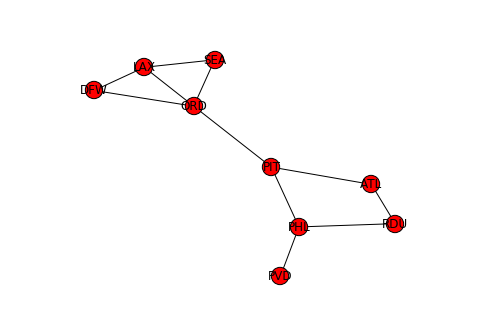

In [21]:
nx.draw(gg,labels=labels)

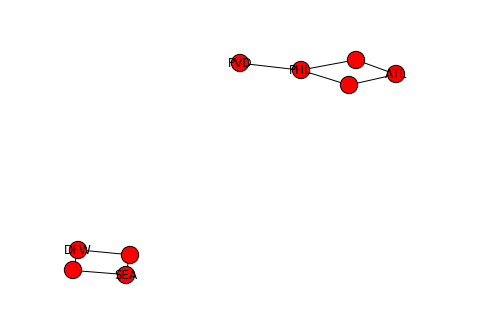

In [22]:
gg_test, observed = make_network(gg,0.5)
labelsss={}
for node in observed:
    labelsss[node]=node
nx.draw(gg_test,labels=labelsss)

In [85]:
test = make_network(G,0.1)

In [86]:
print len(G.nodes()),len(G.edges())
print len(test.nodes()),len(test.edges())

75879 405740
75537 402042
